In [33]:
!wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
!unzip -qq data.zip

--2025-12-02 04:29:36--  https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/405934815/e712cf72-f851-44e0-9c05-e711624af985?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-02T05%3A10%3A24Z&rscd=attachment%3B+filename%3Ddata.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-02T04%3A09%3A40Z&ske=2025-12-02T05%3A10%3A24Z&sks=b&skv=2018-11-09&sig=oRrOB2SMa5TM%2FpgNA0CtfGz9pIsCWeohyjD%2FW0qNues%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDY1MTU3NiwibmJmIjoxNzY0NjQ5Nzc2LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi

In [1]:
import numpy as np
import torch

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
from PIL import Image

In [4]:
img = Image.open('/content/data/train/curly/00cbad1ffe22d900018e5a2e7376daed4.jpg')

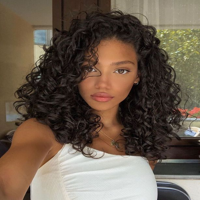

In [6]:
img.resize((200, 200))

In [8]:
X = np.array(img.resize((200, 200)))
X.shape

(200, 200, 3)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: (3, 200, 200)
        self.conv = nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=0
        )
        self.pool = nn.MaxPool2d(kernel_size=2)

        # After conv: (32, 198, 198)
        # After pool: (32, 99, 99)
        flattened_size = 32 * 99 * 99

        self.fc1 = nn.Linear(flattened_size, 64)
        self.fc2 = nn.Linear(64, 1)  # single output neuron

    def forward(self, x):
        x = self.conv(x)        # (3,200,200) -> (32,198,198)
        x = F.relu(x)
        x = self.pool(x)        # (32,198,198) -> (32,99,99)

        x = torch.flatten(x, 1) # (batch, 32*99*99)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)         # logits for binary classification
        return x

    def predict_proba(self, x):
        """Apply sigmoid to get probabilities (for inference)."""
        logits = self.forward(x)
        return torch.sigmoid(logits)


model = SimpleCNN()

# Optimizer as specified
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

# Recommended loss for this setup (binary classification with 1 logit output)
criterion = nn.BCEWithLogitsLoss()

In [11]:
# Option 1: Using torchsummary (install with: pip install torchsummary)
from torchsummary import summary
summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
         MaxPool2d-2           [-1, 32, 99, 99]               0
            Linear-3                   [-1, 64]      20,072,512
            Linear-4                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 11.96
Params size (MB): 76.57
Estimated Total Size (MB): 89.00
----------------------------------------------------------------


In [12]:
# Option 2: Manual counting
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 20073473


In [15]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# 1. Transforms (same for train and test)
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 2. Datasets using your directory structure
train_dataset = datasets.ImageFolder(
    root="/content/data/train",
    transform=transform
)

test_dataset = datasets.ImageFolder(
    root="/content/data/test",
    transform=transform
)

# 3. DataLoaders (batch_size=20, shuffle settings as instructed)
train_loader = DataLoader(
    train_dataset,
    batch_size=20,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=20,
    shuffle=False
)

print("Classes:", train_dataset.classes)

Classes: ['curly', 'straight']


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [20]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'test_acc': [], 'test_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    test_running_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_epoch_loss = test_running_loss / len(test_dataset)
    test_epoch_acc = correct_test / total_test
    history['test_loss'].append(test_epoch_loss)
    history['test_acc'].append(test_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Test Loss: {test_epoch_loss:.4f}, Test Acc: {test_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6039, Acc: 0.6837, Test Loss: 0.6361, Test Acc: 0.6318
Epoch 2/10, Loss: 0.5361, Acc: 0.7288, Test Loss: 0.6149, Test Acc: 0.6617
Epoch 3/10, Loss: 0.4791, Acc: 0.7688, Test Loss: 0.6411, Test Acc: 0.6617
Epoch 4/10, Loss: 0.4175, Acc: 0.8137, Test Loss: 0.6704, Test Acc: 0.6667
Epoch 5/10, Loss: 0.3567, Acc: 0.8438, Test Loss: 0.6324, Test Acc: 0.6816
Epoch 6/10, Loss: 0.3416, Acc: 0.8588, Test Loss: 0.7965, Test Acc: 0.6667
Epoch 7/10, Loss: 0.3499, Acc: 0.8387, Test Loss: 0.7401, Test Acc: 0.6766
Epoch 8/10, Loss: 0.3081, Acc: 0.8662, Test Loss: 0.7363, Test Acc: 0.6965
Epoch 9/10, Loss: 0.1825, Acc: 0.9325, Test Loss: 0.8793, Test Acc: 0.7214
Epoch 10/10, Loss: 0.1285, Acc: 0.9513, Test Loss: 0.8387, Test Acc: 0.7114


In [25]:
np.median(history["acc"])

np.float64(0.84125)

In [26]:
np.std(history["loss"])

np.float64(0.13968655159125126)

In [27]:
train_transforms_aug = transforms.Compose([
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [28]:
train_dataset_aug = datasets.ImageFolder(
    root="/content/data/train",
    transform=train_transforms_aug
)

train_loader_aug = DataLoader(
    train_dataset_aug,
    batch_size=20,
    shuffle=True
)

In [29]:
num_epochs = 10
aug_history = {'acc': [], 'loss': [], 'test_acc': [], 'test_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader_aug:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset_aug)
    epoch_acc = correct_train / total_train
    aug_history['loss'].append(epoch_loss)
    aug_history['acc'].append(epoch_acc)

    model.eval()
    test_running_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_epoch_loss = test_running_loss / len(test_dataset)
    test_epoch_acc = correct_test / total_test
    aug_history['test_loss'].append(test_epoch_loss)
    aug_history['test_acc'].append(test_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Test Loss: {test_epoch_loss:.4f}, Test Acc: {test_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6761, Acc: 0.6400, Test Loss: 0.5899, Test Acc: 0.6617
Epoch 2/10, Loss: 0.5974, Acc: 0.6737, Test Loss: 0.6193, Test Acc: 0.6716
Epoch 3/10, Loss: 0.5738, Acc: 0.6850, Test Loss: 0.6100, Test Acc: 0.6667
Epoch 4/10, Loss: 0.5560, Acc: 0.6975, Test Loss: 0.5705, Test Acc: 0.6965
Epoch 5/10, Loss: 0.5267, Acc: 0.7188, Test Loss: 0.6223, Test Acc: 0.6567
Epoch 6/10, Loss: 0.5216, Acc: 0.7425, Test Loss: 0.6147, Test Acc: 0.6965
Epoch 7/10, Loss: 0.5322, Acc: 0.7188, Test Loss: 0.5986, Test Acc: 0.6866
Epoch 8/10, Loss: 0.5145, Acc: 0.7400, Test Loss: 0.6193, Test Acc: 0.7015
Epoch 9/10, Loss: 0.4958, Acc: 0.7388, Test Loss: 0.5816, Test Acc: 0.7164
Epoch 10/10, Loss: 0.4672, Acc: 0.7700, Test Loss: 0.5533, Test Acc: 0.7065


In [30]:
np.mean(aug_history["test_loss"])

np.float64(0.5979600555119823)

In [31]:
np.mean(aug_history["test_acc"][5:])

np.float64(0.7014925373134329)

In [32]:
aug_history["test_acc"][5:]

[0.6965174129353234,
 0.6865671641791045,
 0.7014925373134329,
 0.7164179104477612,
 0.7064676616915423]